In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

In [2]:
data = 'plantvillage-dataset/color/Apple'
class_folds = os.listdir(data) # Alt klasörlerin listesi

def create_dataframe(data_path):
    # Görüntü dosyalarının yolunu ve etiketlerini tutacak listeler
    filepaths = []
    labels = []

    try:
        folds = os.listdir(data_path)  # Ana klasördeki alt klasörlerin listesi
    except FileNotFoundError:
        print(f"Veri yolu bulunamadı: {data_path}")
        return pd.DataFrame()  # Boş DataFrame döndür

    for fold in folds:
        f_path = os.path.join(data_path, fold) #  Alt klasör yolunu (fold) ve ana veri yolu (data_path) birleştirerek alt klasörün tam yolunu oluşturuyoruz
        try:
            imgs = os.listdir(f_path)  # Alt klasördeki görüntü dosyalarının listesi
        except FileNotFoundError:
            print(f"Klasör bulunamadı: {f_path}")
            continue
        
        for img in imgs:
            img_path = os.path.join(f_path, img) # Görüntü dosyasının tam yolu
            filepaths.append(img_path) # Görüntü dosyasının yolunu (img_path) 'filepaths' listesine, görüntünün sınıf etiketini (fold) 'labels' listesine ekliyoruz
            labels.append(fold)

    # 'filepaths' ve 'labels' listelerini pandas serilerine dönüştürüyoruz
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # 'fseries' ve 'lseries' Serilerini birleştirerek bir DataFrame oluşturuyoruz ve döndürüyoruz
    return pd.concat([fseries, lseries], axis=1)

df = create_dataframe(data)

In [3]:
df.head()

Filepaths              Labels
0  plantvillage-dataset/color/Apple\Apple___Apple...  Apple___Apple_scab
1  plantvillage-dataset/color/Apple\Apple___Apple...  Apple___Apple_scab
2  plantvillage-dataset/color/Apple\Apple___Apple...  Apple___Apple_scab
3  plantvillage-dataset/color/Apple\Apple___Apple...  Apple___Apple_scab
4  plantvillage-dataset/color/Apple\Apple___Apple...  Apple___Apple_scab

In [4]:
df.shape

(3171, 2)

In [5]:
#  'Labels' sütunundaki benzersiz sınıf etiketlerini
np.unique(df['Labels'])

array(['Apple___Apple_scab', 'Apple___Black_rot',
       'Apple___Cedar_apple_rust', 'Apple___healthy'], dtype=object)

In [7]:
# Her sınıftaki görüntülerin sayısı
class_counts = df['Labels'].value_counts()
class_counts

Labels
Apple___healthy             1645
Apple___Apple_scab           630
Apple___Black_rot            621
Apple___Cedar_apple_rust     275
Name: count, dtype: int64

c:\Users\Mihriban\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Mihriban\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Mihriban\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


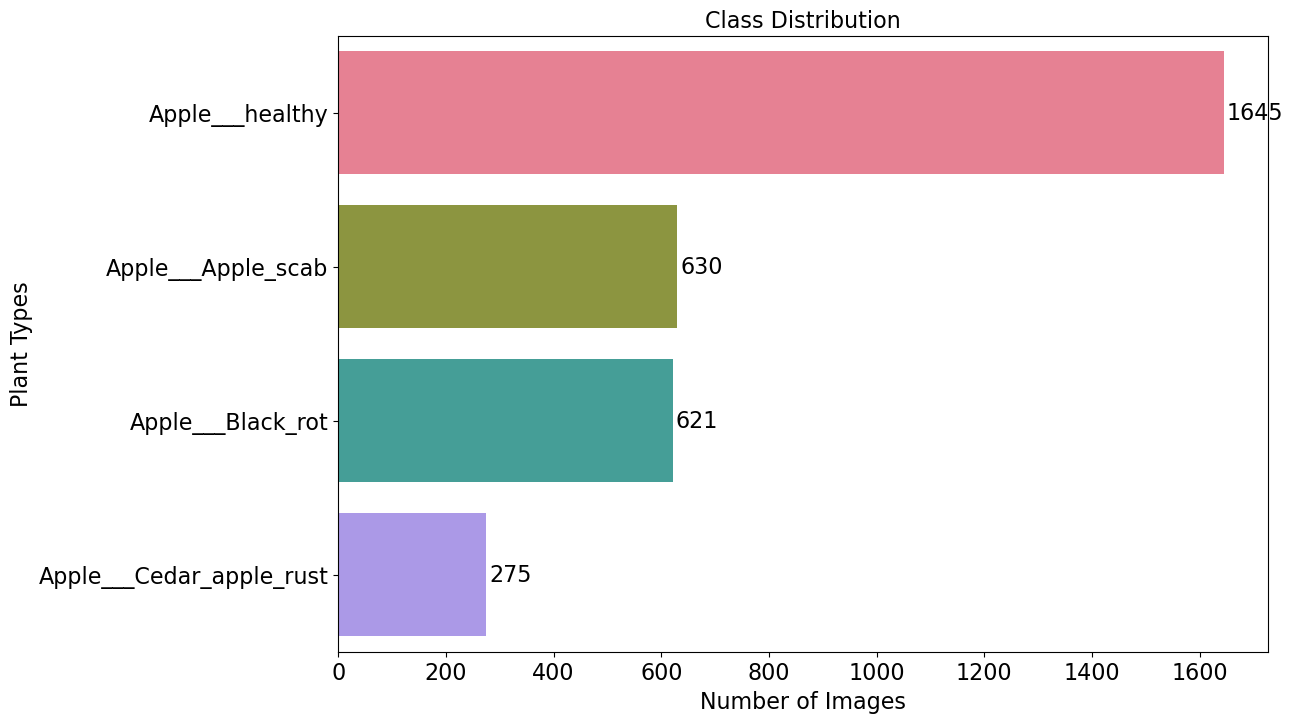

In [14]:
# Sınıf dağılım grafiği
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", len(class_counts))
ax = sns.barplot(x = class_counts.values, y = class_counts.index, palette=palette)
plt.title('Class Distribution', fontsize = 16)
plt.xlabel('Number of Images', fontsize = 16)
plt.ylabel('Plant Types', fontsize = 16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Her bir çubuğa veri etiketlerini ekle
for i, v in enumerate(class_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center', fontsize = 16)

plt.show()

In [15]:
# Verinin eğitim ve test setlerine bölünmesi
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [16]:
train_df.shape, test_df.shape

((2536, 2), (635, 2))

In [17]:
# Eğitim verisinin eğitim ve doğrulama setlerine bölünmesi (eğitim %70, doğrulama %10)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

In [18]:
train_df.shape, val_df.shape

((2219, 2), (317, 2))

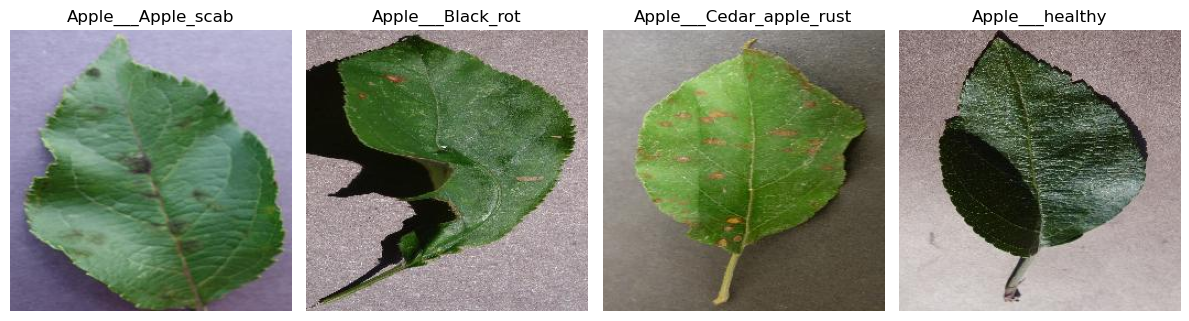

In [12]:
# Her sınıftan örnek görsellerin görüntülenmesi
plt.figure(figsize=(12, 8))

for i, plant_class in enumerate(df['Labels'].unique()):
    plt.subplot(1, 4, i + 1)
    
    # Her sınıf için bir örnek görüntü yolunu belirler
    image_path = df[df['Labels'] == plant_class]['Filepaths'].iloc[0]


    # Görüntü yolunun mevcut olup olmadığını kontrol eder
    if os.path.exists(image_path):
        sample_image = cv2.imread(image_path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(plant_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {image_path}")
    else:
        print(f"Error: Image path does not exist: {image_path}")

plt.tight_layout()
plt.show()

In [13]:
# Eğitim verisi artırma ve yeniden ölçeklendirme için ayar
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Yeniden ölçeklendirme
    rotation_range=20,  # Rastgele döndürme aralığı
    width_shift_range=0.2,  # Rastgele yatay kaydırma aralığı
    height_shift_range=0.2,  # Rastgele dikey kaydırma aralığı
    shear_range=0.2,  # Rastgele kesme aralığı
    zoom_range=0.2,  # Rastgele yakınlaştırma aralığı
    horizontal_flip=True,  # Rastgele yatay döndürme
    fill_mode='nearest'  # Doldurma modu
)

# Doğrulama ve test verisi için yeniden ölçeklendirme
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# DataFrame'den veri üreteçleri oluşturma
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),  # Görüntülerin yeniden boyutlandırılacağı hedef boyut
    batch_size=32,  # Her bir eğitim döngüsünde kullanılacak veri yığını boyutu
    class_mode='categorical',  # Sınıf etiketlerinin temsil ediliş şekli
    shuffle=True,  # Verilerin karıştırılması
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 2219 validated image filenames belonging to 4 classes.
Found 317 validated image filenames belonging to 4 classes.
Found 635 validated image filenames belonging to 4 classes.


In [14]:
# Sınıf ağırlıkları hesaplama
class_weights = dict(enumerate(np.bincount(train_df['Labels'].factorize()[0])))
class_weights

{0: 1178, 1: 420, 2: 179, 3: 442}

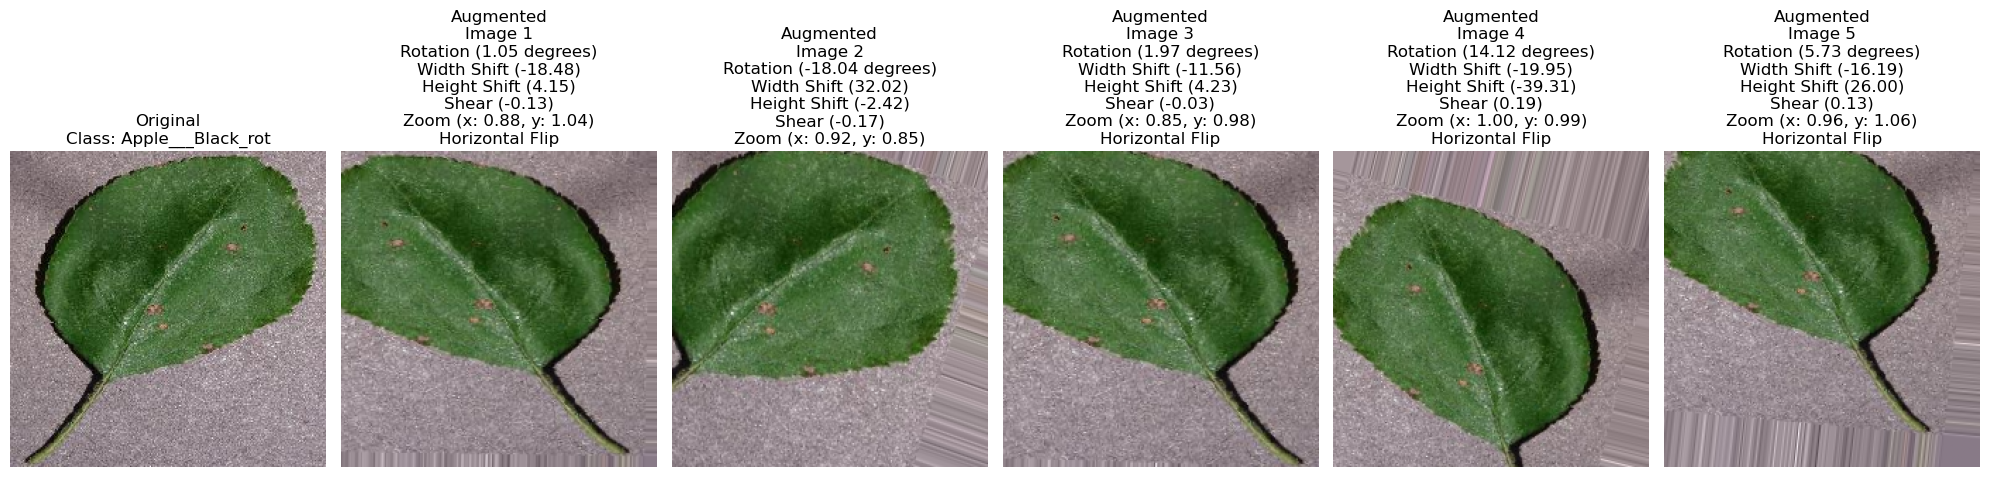

In [15]:
def get_augmentation_description(params):
    """Uygulanan dönüşümleri açıklayan bir metin oluştur."""
    description = []
    if params.get('theta', 0) != 0:
        description.append(f"Rotation ({params['theta']:.2f} degrees)")
    if params.get('tx', 0) != 0:
        description.append(f"Width Shift ({params['tx']:.2f})")
    if params.get('ty', 0) != 0:
        description.append(f"Height Shift ({params['ty']:.2f})")
    if params.get('shear', 0) != 0:
        description.append(f"Shear ({params['shear']:.2f})")
    if params.get('zx', 1) != 1 or params.get('zy', 1) != 1:
        description.append(f"Zoom (x: {params['zx']:.2f}, y: {params['zy']:.2f})")
    if params.get('flip_horizontal', False):
        description.append("Horizontal Flip")
    return "\n".join(description)

# Orijinal görüntü ve veri artırma işlemleri uygulanmış görüntüleri yan yana göstermek için bir fonksiyon
def visualize_augmentation(data_generator, dataframe, num_augmented_images=5):
    # Rastgele bir görüntü seçme
    example_image_path = np.random.choice(dataframe['Filepaths'])
    
    # Orijinal görüntüyü yükleme
    original_image = keras_image.load_img(example_image_path, target_size=(224, 224))
    original_image = keras_image.img_to_array(original_image) / 255.0  # Yeniden ölçeklendirme
    original_image_class = os.path.basename(os.path.dirname(example_image_path))  # Orijinal görüntünün sınıfı

    # Veri artırma işlemlerini uygulama ve parametreleri kaydetme
    augmented_images = []
    augmentation_params = []
    for _ in range(num_augmented_images):
        params = data_generator.get_random_transform(original_image.shape)
        aug_image = data_generator.apply_transform(original_image, params)
        augmented_images.append(aug_image)
        augmentation_params.append(params)

    # Görüntüleri görselleştirme
    plt.figure(figsize=(20, 10))
    
    # Orijinal görüntüyü gösterme
    plt.subplot(1, num_augmented_images + 1, 1)
    plt.imshow(original_image)
    plt.title(f"Original\nClass: {original_image_class}")
    plt.axis('off')
    
    # Veri artırma işlemleri uygulanmış görüntüleri ve uygulanan işlemleri gösterme
    for i, (img, params) in enumerate(zip(augmented_images, augmentation_params)):
        plt.subplot(1, num_augmented_images + 1, i + 2)
        plt.imshow(img)
        # Uygulanan işlemleri belirtmek için başlık
        param_text = get_augmentation_description(params)
        plt.title(f"Augmented\nImage {i + 1}\n{param_text}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Veri çerçevesi: df (Örnek görüntü yolu: rastgele seçilen bir görüntü)
visualize_augmentation(train_datagen, df)

In [16]:
# Veri artırımı sonrası toplam görüntü sayısını hesaplama
def calculate_augmented_images(dataframe, batch_size):
    # Toplam orijinal görüntü sayısı
    total_original_images = len(dataframe)
    # Her bir orijinal görüntü için oluşturulacak görüntü sayısı (batch_size kadar)
    total_augmented_images = total_original_images * batch_size
    return total_augmented_images

# Eğitim seti için veri artırımı sonrası toplam görüntü sayısını yazdırma
total_augmented_images = calculate_augmented_images(train_df, train_generator.batch_size)
print(f"Total augmented images: {total_augmented_images}")


Total augmented images: 71008


In [40]:
xception_base_model  = tf.keras.applications.xception.Xception(weights= 'imagenet', include_top = False ,
                                                     input_shape = (224,224,3), pooling = 'avg'   )
""" ImageNet veri kümesinde önceden eğitilmiş ağırlıklar kullanıldı
    modelin üst kısmındaki tam bağlı katmanlar dahil edilmedi """
xception_model = Sequential([
    xception_base_model,
    BatchNormalization(),  # Normalleştirme katmanı, modelin öğrenme sürecini stabilize etmek için eklendi
    Dense(256,activation = 'relu'),  # Modelin veri setindeki özellikleri daha derinlemesine öğrenmesi
    Dropout(0.5),  # ağdaki aşırı uyumu azaltmak için
    Dense(4 , activation= 'softmax' )
])

# Modeli derleme
xception_model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])

# Modeli eğitme
xception_history = xception_model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=5,
    verbose=1,
    validation_steps=None,
    shuffle=False
)

xception_model.save("xception_model.h5")

Epoch 1/5
70/70 [==============================] - 889s 11s/step - loss: 0.3066 - accuracy: 0.9148 - val_loss: 0.2660 - val_accuracy: 0.9748
Epoch 2/5
70/70 [==============================] - 689s 10s/step - loss: 0.0980 - accuracy: 0.9788 - val_loss: 0.1240 - val_accuracy: 0.9937
Epoch 3/5
70/70 [==============================] - 789s 11s/step - loss: 0.0485 - accuracy: 0.9851 - val_loss: 0.0882 - val_accuracy: 0.9937
Epoch 4/5
70/70 [==============================] - 754s 11s/step - loss: 0.0358 - accuracy: 0.9883 - val_loss: 0.0641 - val_accuracy: 0.9874
Epoch 5/5
70/70 [==============================] - 746s 11s/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.0270 - val_accuracy: 0.9905


c:\Users\Mihriban\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Modeli yükleme
xception_model = load_model('xception_model.h5')

In [18]:
# Test seti üzerinde değerlendirme
test_loss_xception, test_accuracy_xception = xception_model.evaluate(test_generator)
print("Xception Test Accuracy:", test_accuracy_xception)


20/20 [==============================] - 49s 2s/step - loss: 0.0226 - accuracy: 0.9984
Xception Test Accuracy: 0.9984251856803894


In [19]:
# Test seti üzerinde tahmin yapma
predictions_xception = xception_model.predict(test_generator)
test_predicted_labels_xception = np.argmax(predictions_xception, axis=1)

# Gerçek etiketleri alma
test_true_labels = test_generator.classes

# Hata analizi için DataFrame oluşturma
error_df_xception = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels_xception})

# Yanlış sınıflandırılan görüntüler
misclassified_images_xception = error_df_xception[error_df_xception['True Label'] != error_df_xception['Predicted Label']]

# Hatalı sınıflandırılmış görüntü sayısını yazdır
print("Toplam hatalı sınıflandırılmış görüntü sayısı:", len(misclassified_images_xception))

20/20 [==============================] - 41s 2s/step
Toplam hatalı sınıflandırılmış görüntü sayısı: 1


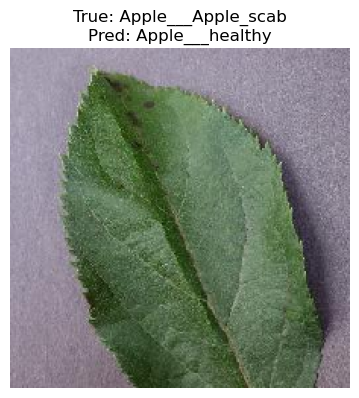

In [20]:
# Yanlış sınıflandırılan görüntülerin görselleştirilmesi
plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images_xception.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # True Label
    pred_label = class_folds[row._2]  # Predicted Label
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

In [21]:
# Etiketler için sınıf sözlüğü
class_labels_dict = {class_label: idx for idx, class_label in enumerate(np.unique(df['Labels']))}
df['Labels'] = df['Labels'].map(class_labels_dict)

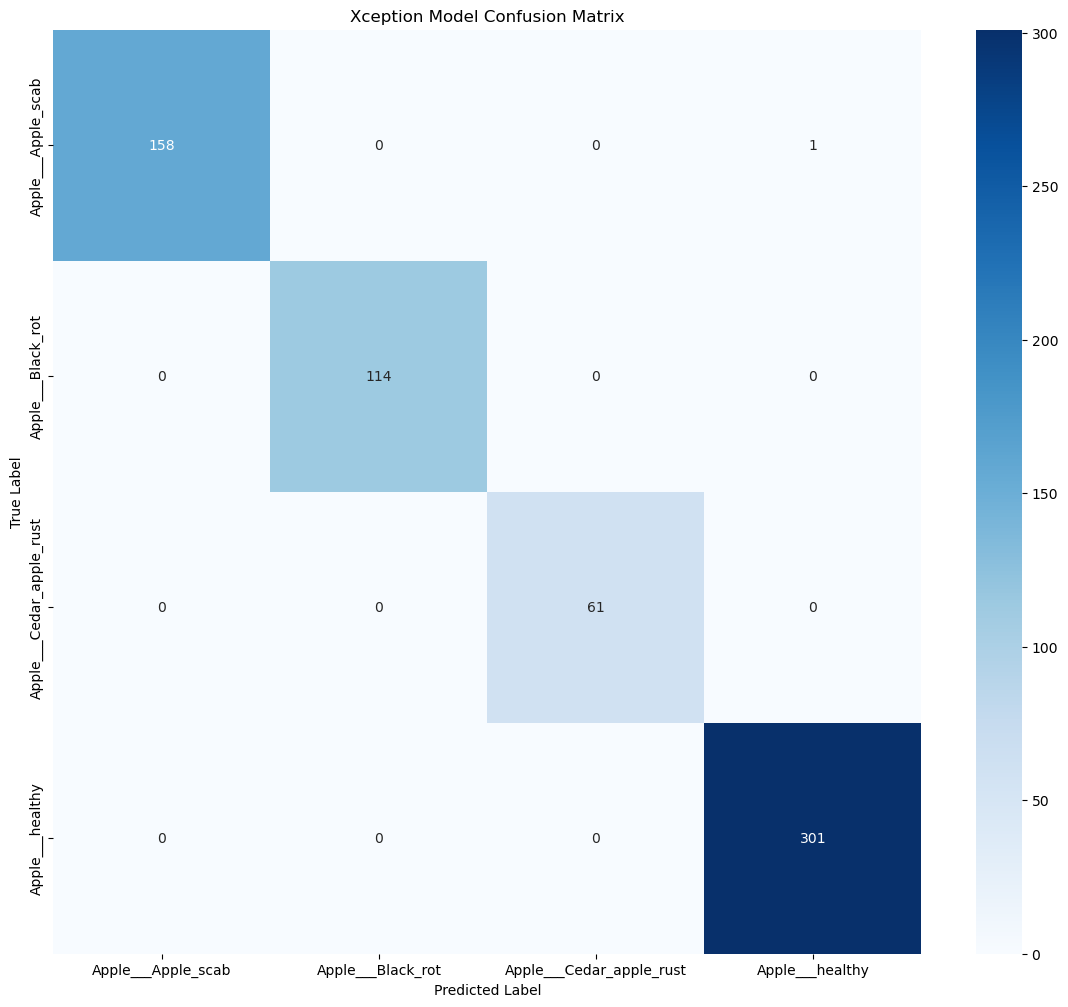

In [22]:
# Karışıklık Matrisi ve Sınıflandırma Raporu
plt.figure(figsize=(14, 12))
conf_matrix_xception = confusion_matrix(test_true_labels, 
                                        test_predicted_labels_xception)
class_names = list(class_labels_dict.keys())
sns.heatmap(conf_matrix_xception, 
            annot=True, fmt='d', 
            cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Xception Model Confusion Matrix')
plt.show()

In [23]:
print(classification_report(test_true_labels, test_predicted_labels_xception, target_names=class_names))

                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      0.99      1.00       159
       Apple___Black_rot       1.00      1.00      1.00       114
Apple___Cedar_apple_rust       1.00      1.00      1.00        61
         Apple___healthy       1.00      1.00      1.00       301

                accuracy                           1.00       635
               macro avg       1.00      1.00      1.00       635
            weighted avg       1.00      1.00      1.00       635



In [62]:
# InceptionV3 tabanlı model
inception_model = Sequential([
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Modeli derleme
inception_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
inception_history = inception_model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=5,
    verbose=1,
    validation_steps=None,
    shuffle=False
)

# Modeli kaydetme
inception_model.save("inception_model.h5")

Epoch 1/5
70/70 [==============================] - 349s 5s/step - loss: 0.4890 - accuracy: 0.8765 - val_loss: 10.8690 - val_accuracy: 0.5331
Epoch 2/5
70/70 [==============================] - 305s 4s/step - loss: 0.1170 - accuracy: 0.9608 - val_loss: 6.1930 - val_accuracy: 0.6656
Epoch 3/5
70/70 [==============================] - 297s 4s/step - loss: 0.0407 - accuracy: 0.9851 - val_loss: 0.0921 - val_accuracy: 0.9716
Epoch 4/5
70/70 [==============================] - 297s 4s/step - loss: 0.0750 - accuracy: 0.9730 - val_loss: 0.0344 - val_accuracy: 0.9842
Epoch 5/5
70/70 [==============================] - 298s 4s/step - loss: 0.0478 - accuracy: 0.9851 - val_loss: 0.0223 - val_accuracy: 0.9874


c:\Users\Mihriban\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
# Modeli yükleme
inception_model = load_model('inception_model.h5')

In [64]:
# Test veri seti üzerinde değerlendirme
test_loss_inception, test_accuracy_inception = inception_model.evaluate(test_generator)
print("InceptionV3 Test Accuracy:", test_accuracy_inception)

20/20 [==============================] - 20s 878ms/step - loss: 0.0477 - accuracy: 0.9858
InceptionV3 Test Accuracy: 0.9858267903327942


In [65]:
# Test seti üzerinde tahminler yapılması
predictions_inception = inception_model.predict(test_generator)
test_predicted_labels_inception = np.argmax(predictions_inception, axis=1)

# Gerçek etiketlerin alınması
test_true_labels = test_generator.classes

# Hatalı sınıflandırılmış görüntülerin belirlenmesi
error_df_inception = pd.DataFrame({'True Label': test_true_labels, 'Predicted Label': test_predicted_labels_inception})
misclassified_images_inception = error_df_inception[error_df_inception['True Label'] != error_df_inception['Predicted Label']]

20/20 [==============================] - 20s 906ms/step


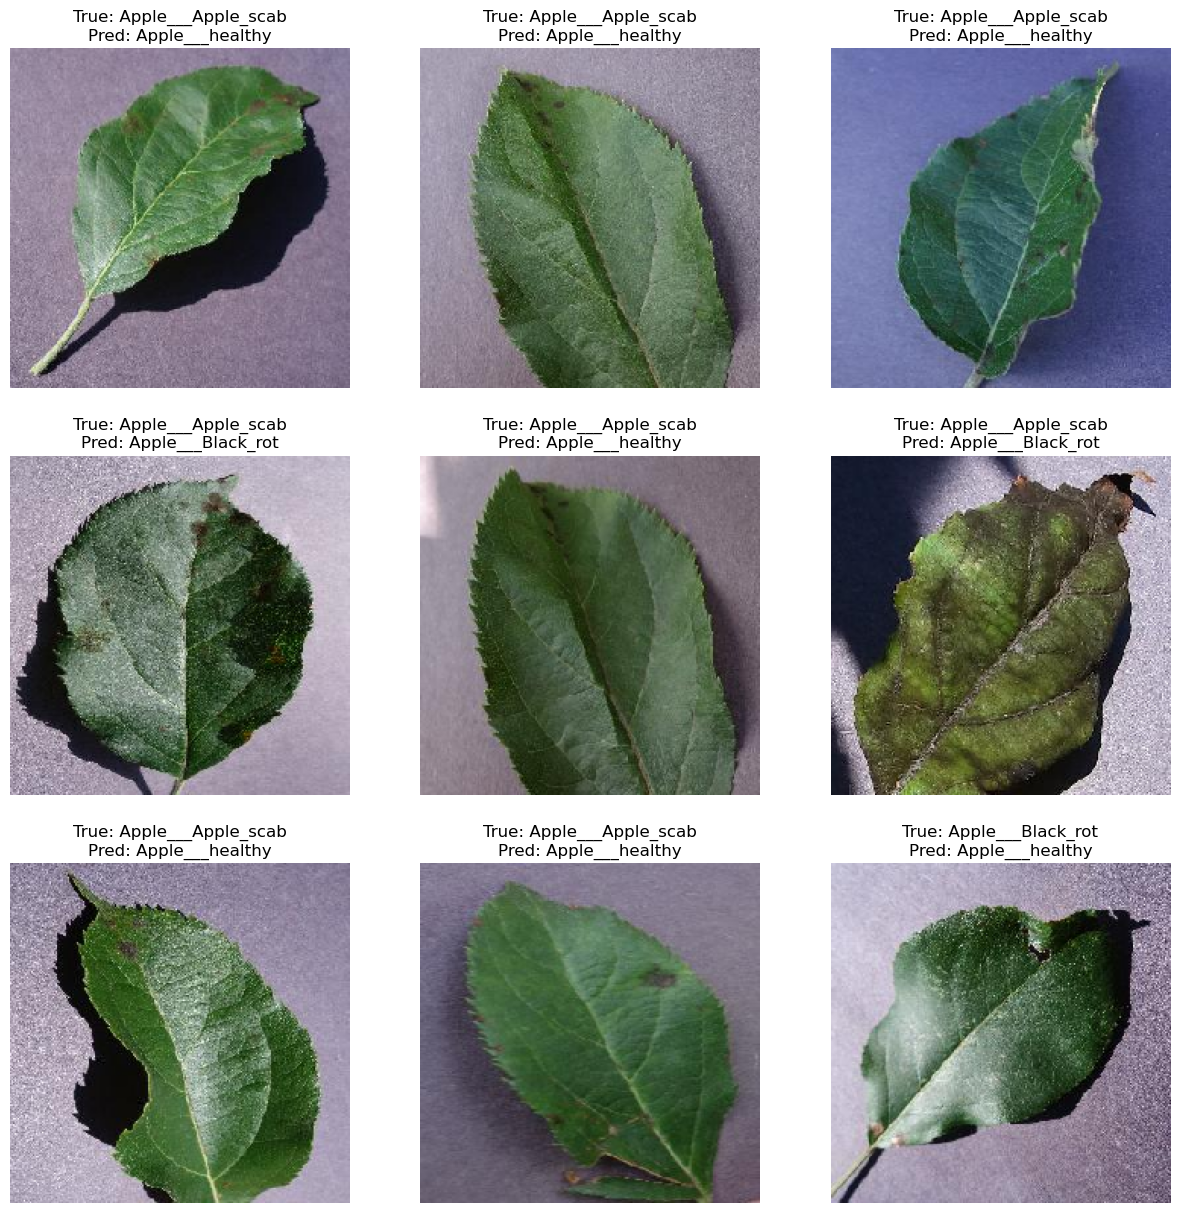

In [66]:
# Hatalı sınıflandırılmış görüntülerin görselleştirilmesi
plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images_inception.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]
    pred_label = class_folds[row._2]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

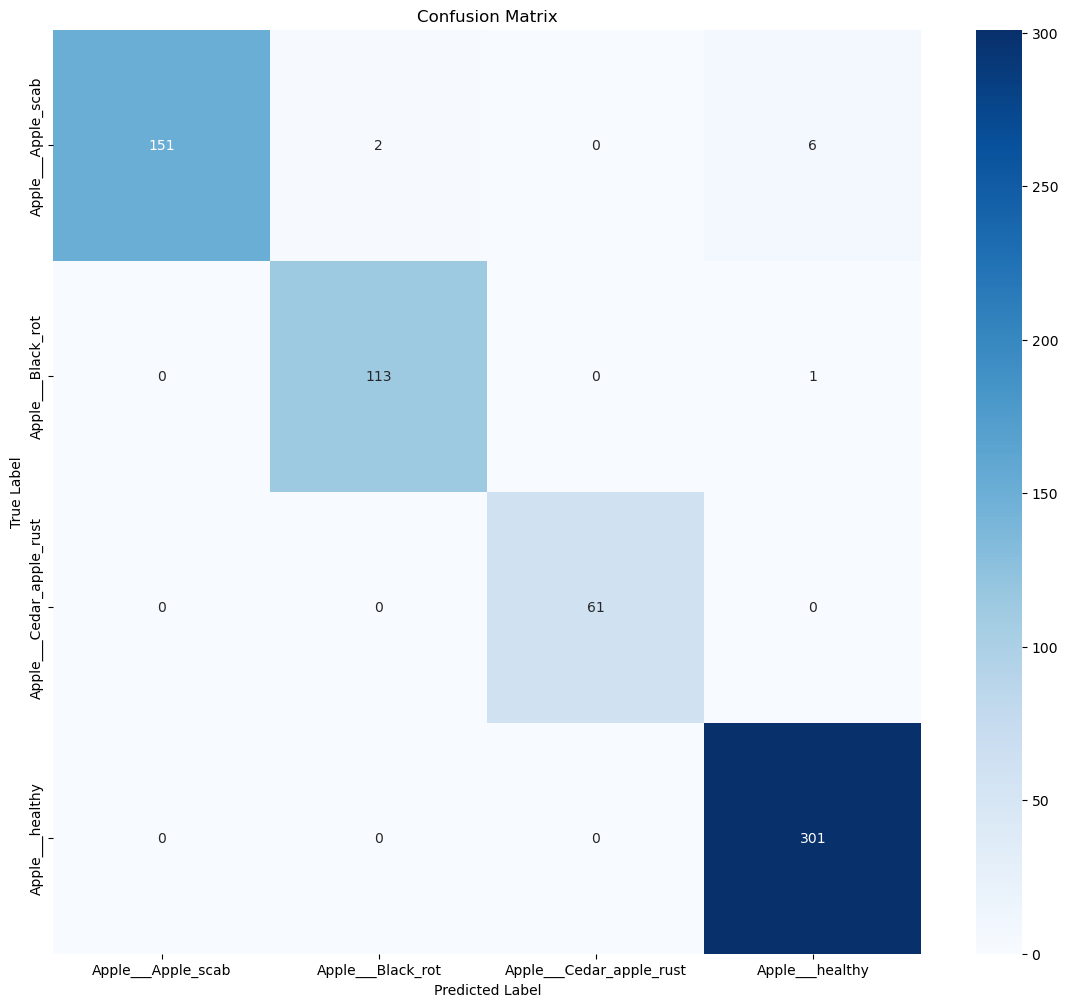

In [67]:
# Karışıklık Matrisi ve Sınıflandırma Raporu
plt.figure(figsize=(14, 12))
conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels_inception)
class_names = list(class_labels_dict.keys())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [68]:
print(classification_report(test_true_labels, test_predicted_labels_inception, target_names=class_names))

                          precision    recall  f1-score   support

      Apple___Apple_scab       1.00      0.95      0.97       159
       Apple___Black_rot       0.98      0.99      0.99       114
Apple___Cedar_apple_rust       1.00      1.00      1.00        61
         Apple___healthy       0.98      1.00      0.99       301

                accuracy                           0.99       635
               macro avg       0.99      0.99      0.99       635
            weighted avg       0.99      0.99      0.99       635

